PDHG algorithm

In [36]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN , gradient
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask, \
                    gridded_inverse_fourier_transform_nd
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data
import time

In [2]:
from modopt.math.metrics import ssim

import numpy as np
import matplotlib.pyplot as plt

## Import data and add noise

### Radial Fourier operator

In [4]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data*(1+0j)

In [42]:
n_rad = 500
n_ang = 200

#num_blocks = ( n_rad - 1 ) * n_ang + 1 # for sampling isolated points
num_blocks = n_ang # for choosing radia
#num_blocks = n_rad # for choosing circles
nb_samples = int( num_blocks * 2 / np.pi )

phi = np.linspace( 0, 2 * np.pi, n_ang, endpoint = False )
rad = np.linspace( 0.5 / n_rad, 0.5, (n_rad-1), endpoint = False )
Phi, Rad = np.meshgrid( phi, rad )

X = ( Rad * np.cos( Phi ) ).flatten( 'C' )
Y = ( Rad * np.sin( Phi ) ).flatten( 'C' )

full_kspace_loc = np.stack( ( X, Y ), axis = 1 )  
full_kspace_loc = np.vstack( ( np.array( [ 0, 0 ] ), full_kspace_loc ) )

m = convert_locations_to_mask(full_kspace_loc,u0_mat.shape)
fourier_op = NonCartesianFFT(samples=full_kspace_loc, shape=u0_mat.shape,implementation='cpu')
y = (1+0j)*fourier_op.op(u0_mat)+5e-7*np.random.randn(2*n_ang*(n_rad-1)+2).view(np.complex128)

p = np.ones(n_ang*(n_rad-1)+1)

In [43]:
pysap.Image(data=m).show()

### Operators

In [44]:
#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=4,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

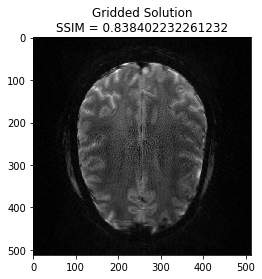

In [45]:
grid_space = np.linspace(-0.5, 0.5, num=u0_mat.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)
grid_soln = gridded_inverse_fourier_transform_nd(full_kspace_loc, y,
                                                 tuple(grid2D), 'linear')
plt.imshow(np.abs(grid_soln), cmap='gray')
# Calculate SSIM
base_ssim = ssim(grid_soln, u0_mat)
plt.title('Gridded Solution\nSSIM = ' + str(base_ssim))
plt.show()

## Reconstruction

In [46]:
# Specific files import
from LowerLevel.prox import prox_G,prox_F1_dual,prox_F2_dual
from LowerLevel.pdhg import pdhg
from LowerLevel.cost_utils import f1,f2,g

In [47]:
param = {"pn1":5e-7,"epsilon":1e-2,"gamma":1e-10}

In [50]:
print(g(u0_mat,param["epsilon"]),f2(linear_op.op(u0_mat),param["pn1"],param["gamma"]),f1(u0_mat,p,y,fourier_op))

1.9073479506915346e-08 5.533938854932785e-08 2.497970831380562e-08


In [30]:
# -- Solving --
# myconst = {"sigma":0.4,"tau":1.1}
uk,norms,energy,ssims = pdhg(y,np.ones(n_ang*(n_rad-1)+1),fourier_op,linear_op,param,ground_truth=u0_mat,maxit=10)

Sigma: 10.0 
Tau: 0.05
10  iterations:
Cost: 2.532540914366268e+23 
Norm: 6.181624913876573 

Finished in 4.580708980560303 seconds.


In [31]:
#Showing
print(ssim(u0_mat,uk))
pysap.Image(data = np.abs(uk)).show()

0.20851557132976445


In [26]:
pysap.Image(data = np.abs(uk-u0_mat)).show()

In [14]:
pysap.Image(data = np.arctan(np.imag(uk)/np.real(uk))).show()

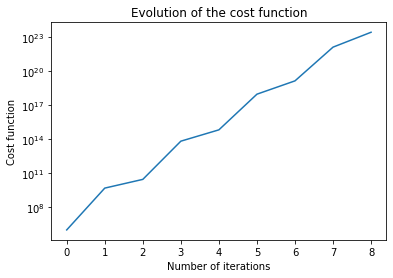

In [27]:
plt.plot(energy[1:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("Cost function")
plt.title("Evolution of the cost function")
plt.yscale("log")
#plt.savefig("Comparisons/haar/pdhg/Complex/energy.png")
plt.show()

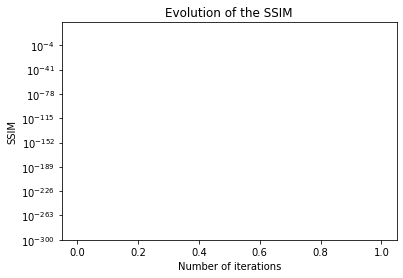

In [28]:
plt.plot(ssims[10:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("SSIM")
plt.title("Evolution of the SSIM")
plt.yscale("log")
#plt.savefig("Comparisons/haar/pdhg/Complex/metrics.png")
plt.show()

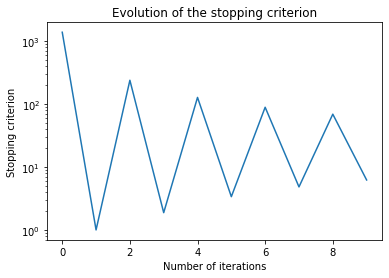

In [29]:
plt.plot(norms)
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("Stopping criterion")
plt.title("Evolution of the stopping criterion")
plt.yscale("log")
#plt.savefig("Comparisons/haar/pdhg/Complex/norms.png")
plt.show()

## Grid search over parameters

In [80]:
alphas = 0.8e-6*np.logspace(-0.5,0.5,7)
eps = 1e-6*np.logspace(-2,2,7)
ssims = np.zeros((7,7))
conv = np.zeros((7,7))
energies = np.zeros((7,7))
niter=50

for i in range(7):
    for j in range(7):
        param["pn1"]=alphas[i]
        param["epsilon"]=eps[j]
        uk,norms,energy = pdhg(y,p,fourier_op,linear_op,param,maxit=niter,verbose=0)
        
        energies[i,j]=energy[-1]
        conv[i,j]=norms[-1]
        ssims[i,j]=ssim(uk,u0_mat)
        print(f"({alphas[i]},{eps[j]}):\nssim:{ssims[i,j]}\nenergy:{energies[i,j]}\nnorm:{conv[i,j]}\n")

Sigma: 0.034641016151377546 
Tau: 14.433756729740644
Finished in 30.93004870414734 seconds.
(2.5298221281347034e-07,1e-08):
ssim:0.8858939434227681
energy:2.291542144519251e-08
norm:0.017579801323807993

Sigma: 0.034641016151377546 
Tau: 14.433756729740644
Finished in 34.45823001861572 seconds.
(2.5298221281347034e-07,4.6415888336127774e-08):
ssim:0.8858941298190194
energy:2.2915486136269244e-08
norm:0.01757977510456446

Sigma: 0.034641016151377546 
Tau: 14.433756729740644
Finished in 30.773914098739624 seconds.
(2.5298221281347034e-07,2.1544346900318832e-07):
ssim:0.8858949644530555
energy:2.2915784056538376e-08
norm:0.017579609952735283

Sigma: 0.034641016151377546 
Tau: 14.433756729740644
Finished in 31.65312361717224 seconds.
(2.5298221281347034e-07,1e-06):
ssim:0.8858987824338026
energy:2.2917161841241576e-08
norm:0.017578749959945465

Sigma: 0.034641016151377546 
Tau: 14.433756729740644
Finished in 32.23435950279236 seconds.
(2.5298221281347034e-07,4.641588833612778e-06):
ssim:0.

Finished in 28.338058948516846 seconds.
(1.7235477520255066e-06,4.641588833612778e-06):
ssim:0.9188438691151466
energy:1.2094511591160174e-07
norm:0.015415142103790563

Sigma: 0.034641016151377546 
Tau: 14.433756729740644
Finished in 28.82965087890625 seconds.
(1.7235477520255066e-06,2.154434690031882e-05):
ssim:0.9188354416047472
energy:1.2097419349207793e-07
norm:0.015409076668677087

Sigma: 0.034641016151377546 
Tau: 14.433756729740644
Finished in 29.5209641456604 seconds.
(1.7235477520255066e-06,9.999999999999999e-05):
ssim:0.9187985134589138
energy:1.2110919056469088e-07
norm:0.015381160702221286

Sigma: 0.034641016151377546 
Tau: 14.433756729740644
Finished in 30.224624395370483 seconds.
(2.5298221281347034e-06,1e-08):
ssim:0.9023833370607135
energy:1.702979808587668e-07
norm:0.015125426624286566

Sigma: 0.034641016151377546 
Tau: 14.433756729740644
Finished in 29.394991874694824 seconds.
(2.5298221281347034e-06,4.6415888336127774e-08):
ssim:0.9023832491340615
energy:1.7029804338

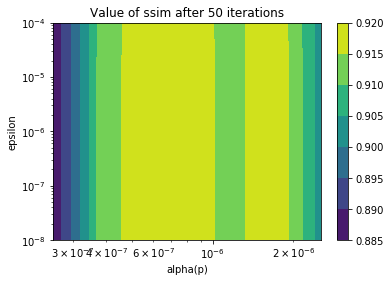

In [81]:
X,Y = np.meshgrid(alphas,eps)
const_to_test = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

plt.contourf(X,Y,ssims.transpose())
plt.title(f"Value of ssim after {niter} iterations")
plt.xlabel("alpha(p)")
plt.ylabel("epsilon")
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
#plt.savefig("Comparisons/db8/pdhg/Complex/ssims.png")
plt.show()

In [82]:
print(alphas[np.argmax(ssims)//7],eps[np.argmax(ssims)%7])

5.450336552463689e-07 1e-08


## Gridsearch on sigma and tau

In [50]:
taus = np.logspace(-2,2,7)
sigmas = np.logspace(-2,2,7)
ssims = np.zeros((7,7))
conv = np.zeros((7,7))
energies = np.zeros((7,7))
niter=20
param = {"pn1":5.5e-7,"epsilon":1e-8,"gamma":1e-10}

for i in range(7):
    for j in range(7):
        uk,norms,energy = pdhg(y,p,fourier_op,linear_op,param,{"sigma":sigmas[i],"tau":taus[j]},
                               maxit=niter,verbose=0)
        
        energies[i,j]=energy[-1]
        conv[i,j]=norms[-1]
        ssims[i,j]=ssim(uk,u0_mat)
        print(f"({sigmas[i]},{taus[j]}):\nssim:{ssims[i,j]}\nenergy:{energies[i,j]}\nnorm:{conv[i,j]}\n")

Sigma: 0.01 
Tau: 0.01
Finished in 11.090649604797363 seconds.
(0.01,0.01):
ssim:0.7534609585680333
energy:1.1080457092460673e-07
norm:0.02130718420361378

Sigma: 0.01 
Tau: 0.046415888336127774
Finished in 12.154165029525757 seconds.
(0.01,0.046415888336127774):
ssim:0.44487155604984613
energy:1.2864614913476e-06
norm:0.1767733169653768

Sigma: 0.01 
Tau: 0.21544346900318834
Finished in 19.401995420455933 seconds.
(0.01,0.21544346900318834):
ssim:0.6451613615167647
energy:2.0491034945596974e-05
norm:0.1240679897244884

Sigma: 0.01 
Tau: 1.0
Finished in 16.67427897453308 seconds.
(0.01,1.0):
ssim:0.7660668672422338
energy:0.00010208177023431531
norm:0.26392136159387447

Sigma: 0.01 
Tau: 4.6415888336127775
Finished in 15.003008604049683 seconds.
(0.01,4.6415888336127775):
ssim:0.7370154457758258
energy:0.0002271279089569359
norm:0.421939989179148

Sigma: 0.01 
Tau: 21.54434690031882
Finished in 12.45137882232666 seconds.
(0.01,21.54434690031882):
ssim:0.6456626632876484
energy:4.261415

Finished in 11.718807935714722 seconds.
(100.0,0.21544346900318834):
ssim:0.8250521827709649
energy:5.808689129309647e-08
norm:1.7170635777956305

Sigma: 100.0 
Tau: 1.0
Finished in 11.446844816207886 seconds.
(100.0,1.0):
ssim:0.11594388942352175
energy:4.863683064980508
norm:5.175830786741024

Sigma: 100.0 
Tau: 4.6415888336127775
Finished in 11.449313163757324 seconds.
(100.0,4.6415888336127775):
ssim:0.1419720076358341
energy:3.928288760674906e+29
norm:19.415943560927385

Sigma: 100.0 
Tau: 21.54434690031882
Finished in 11.82313084602356 seconds.
(100.0,21.54434690031882):
ssim:0.14437460345122868
energy:8.19460782807313e+56
norm:86.31577410949144

Sigma: 100.0 
Tau: 100.0
Finished in 11.822579860687256 seconds.
(100.0,100.0):
ssim:0.14467618425131953
energy:5.320332049008225e+83
norm:397.0216937678108



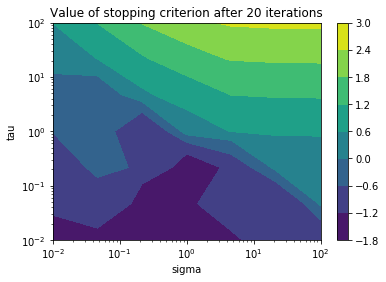

In [52]:
X,Y = np.meshgrid(sigmas,taus)
const_to_test = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

plt.contourf(X,Y,np.log10(conv.transpose()))
plt.title(f"Value of stopping criterion after {niter} iterations")
plt.xlabel("sigma")
plt.ylabel("tau")
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.show()